In [12]:
import numpy as np
from matplotlib import pyplot as plt, cm
%matplotlib inline

In [13]:
sample = 'T1'
# import tsl grain data
grains = np.genfromtxt('Ti7_ESRF_T1_EBSD_beforeEtch_cleaned_grains.txt')
print(len(grains))
grain_fakeids = range(1, len(grains) + 1)  # avoid large ids from TSL

62


Load EBSD data
--

(318, 107)


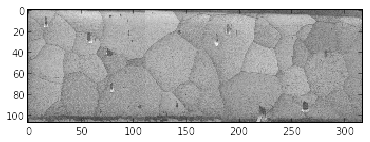

In [14]:
# read the merged ebsd scan data
import h5py
f = h5py.File('Ti7_ESRF_%s_EBSD_beforeEtch_cleaned.h5' % sample)
nrows = f['Ti7_ESRF_T1_EBSDbeforeEtch_cleaned/EBSD/Header/nRows'][0]
ncols = f['Ti7_ESRF_T1_EBSDbeforeEtch_cleaned/EBSD/Header/nColumns'][0]
scan_step = f['Ti7_ESRF_T1_EBSDbeforeEtch_cleaned/EBSD/Header/Step X'][0]
iq = np.reshape(f['Ti7_ESRF_T1_EBSDbeforeEtch_cleaned/EBSD/Data/IQ'], (nrows, ncols)).T  # [x, y] form with x being the horizontal coordinate
f.close()
print(iq.shape)

plt.imshow(iq.T, origin='upper', interpolation='nearest', cmap=cm.gray)

[ 669.616  242.855]
[ 1214.526   198.198]


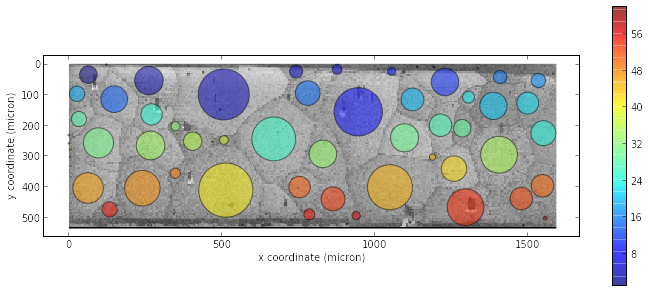

In [15]:
plt.figure(figsize=(12, 5))
plt.imshow(iq.T, origin='upper', interpolation='nearest', cmap=cm.gray,
           extent=(0, scan_step * iq.shape[0], scan_step * iq.shape[1], 0))
plt.scatter(grains[:, 4], grains[:, 5], s=grains[:, 6], c=grain_fakeids, alpha=0.5)
plt.colorbar()
plt.xlabel('x coordinate (micron)')
plt.ylabel('y coordinate (micron)')
#plt.axis('equal')
print(grains[25, 4:6])
print(grains[26, 4:6])

convert to XYZ local frame
--
So far we hae imported data from the EBSD scan (local frame A1A2A3), and we now want to transform the orientation data into the DCT cartesian frame (called XYZ) where the specimen will be standing up with the notched head on top and the polished face facing the X-ray beam.

For this we use a transformation matrix T where X is -A3, Y is -A1 and Z is A2

In [16]:
# transformation matrix from A1A2A3 to XYZ
T = np.array([[ 0., 0., -1.],
              [-1., 0.,  0.],
              [ 0., 1.,  0.]])

from pymicro.crystal.microstructure import Microstructure, Grain, Orientation

micro = Microstructure()
for i in range(len(grains)):
    o_tsl = Orientation.from_euler(grains[i, 1:4])
    g_xyz = np.dot(o_tsl.orientation_matrix(), T.T)  # move to XYZ local frame
    o_xyz = Orientation(g_xyz)
    g = Grain(grain_fakeids[i], o_xyz)
    g.position = np.array([grains[i, 4], grains[i, 5], 0.])
    micro.grains.append(g)


In [60]:
micro.grains[0].id

1

Plot basal slip traces on the surface
--

Crystal Orientation
orientation matrix = [[ 0.26048501 -0.8892749   0.37594909]
 [-0.49552025  0.21105497  0.84256482]
 [-0.82861767 -0.40576589 -0.38567706]]
Euler angles (degrees) = ( 296.091, 112.686,  24.046)
Rodrigues vector = [ 1.14962092 -1.10931753 -0.36261911]


[0, 1589, 534, 0]

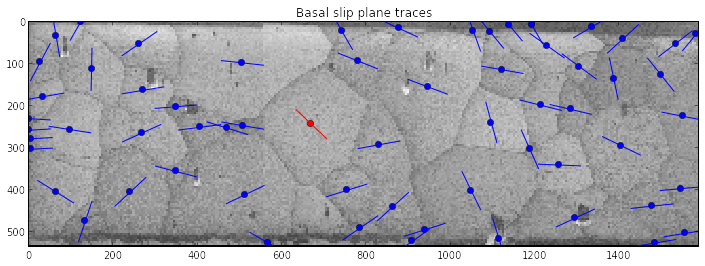

In [17]:
from pymicro.crystal.lattice import Lattice, HklPlane, HklDirection

trace_size = 100  # micron
Ti7Al = Lattice.hexagonal(0.2931, 0.4694)  # nm
p_basal = HklPlane(0, 0, 1, Ti7Al)  # basal plane
n_int = np.array([1, 0, 0])  # since X is going through the sample
view_up = np.array([0, 1, 0])  # here we want a figure with the sample horizontal as in the EBSD

#n_int = np.array([0, 0, -1])  # for orientation data in A1A2A3 (TSL)
#view_up = np.array([1, 0, 0])  # for orientation data in A1A2A3 (TSL)

plt.figure(figsize=(12, 5))
plt.imshow(iq.T, origin='upper', interpolation='nearest', cmap=cm.gray,
           extent=(0, scan_step * iq.shape[0], scan_step * iq.shape[1], 0))

for g in micro.grains:
    trace = p_basal.slip_traces(g.orientation, n_int, view_up, trace_size=100, verbose=False)
    if g.id == 26:
        color = 'r'
        print(g.orientation)
    else:
        color = 'b'
    x = g.position[0] + np.array([-trace[0] / 2, trace[0] / 2])
    y = g.position[1] + np.array([-trace[1] / 2, trace[1] / 2])
    plt.plot(g.position[0], g.position[1], 'o', color=color)
    plt.plot(x, y, 'b-', linewidth=1, color=color)
plt.title('Basal slip plane traces')
plt.axis([0, 1589, 534, 0])

[0, 1589, 534, 0]

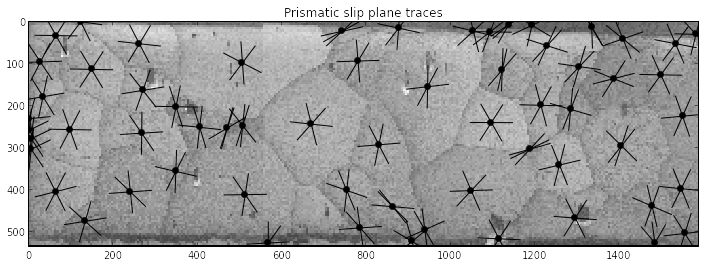

In [18]:
# now try with prismatic planes
import math
import fractions

p_prism1 = HklPlane(0, 1, 0, lattice=Ti7Al)
p_prism2 = HklPlane(-1, 1, 0, lattice=Ti7Al)
p_prism3 = HklPlane(-1, 0, 0, lattice=Ti7Al)
slip_prism = [p_prism1, p_prism2, p_prism3]

n_int = np.array([1, 0, 0])
view_up = np.array([0, 1, 0])

plt.figure(figsize=(12, 5))
plt.imshow(iq.T, origin='upper', interpolation='nearest', cmap=cm.gray,
           extent=(0, scan_step * iq.shape[0], scan_step * iq.shape[1], 0))

for g in micro.grains:
    plt.plot(g.position[0], g.position[1], 'ko')
    for p in slip_prism:
        trace = p.slip_traces(g.orientation, n_int, view_up, trace_size=100, verbose=False)
        x = g.position[0] + np.array([-trace[0] / 2, trace[0] / 2])
        y = g.position[1] + np.array([-trace[1] / 2, trace[1] / 2])
        plt.plot(x, y, 'k-', linewidth=1)
plt.title('Prismatic slip plane traces')
plt.axis([0, 1589, 534, 0])

In [37]:
# compute a field where we check if the basal plane can be aligned with topotomo 
pyr_1 = HklPlane(0, 1, 1, lattice=Ti7Al)
pyr_2 = HklPlane(-1, 1, 1, lattice=Ti7Al)
pyr_3 = HklPlane(-1, 0, -1, lattice=Ti7Al)
pyr_4 = HklPlane(-1, 0, 1, lattice=Ti7Al)
pyr_5 = HklPlane(-1, 1, -1, lattice=Ti7Al)
pyr_6 = HklPlane(0, -1, 1, lattice=Ti7Al)
slip_pyr = [pyr_1, pyr_2, pyr_3, pyr_4, pyr_5, pyr_6]
slip_planes = [p_basal]
slip_planes.extend(slip_prism)
slip_planes.extend(slip_pyr)
hkl_planes = HklPlane.get_family('001', lattice=Ti7Al)
hkl_planes.extend(HklPlane.get_family('011', lattice=Ti7Al))
hkl_planes.extend(HklPlane.get_family('111', lattice=Ti7Al))
hkl_planes.extend(HklPlane.get_family('112', lattice=Ti7Al))
hkl_indices = [hkl.miller_indices() for hkl in hkl_planes]

align = np.empty((len(grains), len(hkl_planes)), dtype=bool)
able_to_align = np.empty(len(grains), dtype=bool)
for i in range(len(grains)):
    g = micro.grains[i]
    for j, p in enumerate(hkl_planes):
        ut, lt = np.array(g.orientation.topotomo_tilts(p)) * 180 / np.pi
        # low tilt (samry) range is +/- 15 deg, up tilt (samrx) range is +/- 20 deg
        align[i, j] = np.prod(np.abs([ut, lt]) < np.array([20, 15]))
    able_to_align[i] = bool(np.sum(align[i]) > 0)
    #print('grain %2d: able to align? %s' % (g.id, able_to_align[i]))

[(1, 0, 0), (0, 1, 0), (0, 0, 1), (1, 1, 0), (-1, 1, 0), (1, 0, 1), (-1, 0, 1), (0, 1, 1), (0, -1, 1), (1, 1, 1), (-1, 1, 1), (1, -1, 1), (1, 1, -1), (1, 1, 2), (-1, 1, 2), (1, -1, 2), (1, 1, -2), (1, 2, 1), (-1, 2, 1), (1, -2, 1), (1, 2, -1), (2, 1, 1), (-2, 1, 1), (2, -1, 1), (2, 1, -1)]


In [72]:
indices_align = np.argwhere(align[25])
for ndx in indices_align:
    print('* possible to align %s' % str(hkl_planes[ndx].miller_indices()))
    ut, lt = np.array(micro.grains[25].orientation.topotomo_tilts(hkl_planes[ndx])) * 180 / np.pi
    print('with ut=%.2f deg and lt = %.2f deg' % (ut, lt))

* possible to align (1, 1, -1)
with ut=2.22 deg and lt = -7.41 deg
* possible to align (1, 1, -2)
with ut=-10.68 deg and lt = -0.41 deg
* possible to align (1, 2, -1)
with ut=12.08 deg and lt = -0.49 deg


[0, 1589, 534, 0]

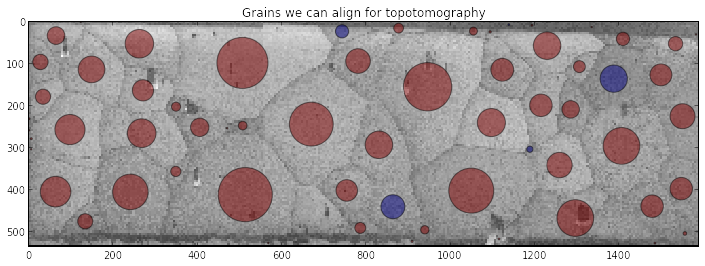

In [25]:
plt.figure(figsize=(12, 5))
plt.imshow(iq.T, origin='upper', interpolation='nearest', cmap=cm.gray,
           extent=(0, scan_step * iq.shape[0], scan_step * iq.shape[1], 0))
plt.scatter(grains[:, 4], grains[:, 5], s=grains[:, 6], c=able_to_align, alpha=0.5)
plt.title('Grains we can align for topotomography')
plt.axis([0, 1589, 534, 0])

In [52]:
hkl_to_align = np.empty(len(grains), dtype=np.int8)
for i in range(len(grains)):
    reflections = np.where(align[i] == True)[0]
    hkl_to_align[i] = -1
    if len(reflections) > 0:
        hkl_to_align[i] = reflections[0]
        #print(hkl_to_align[i], hkl_indices[hkl_to_align[i]])
print(hkl_to_align.max())

19


[0, 1589, 534, 0]

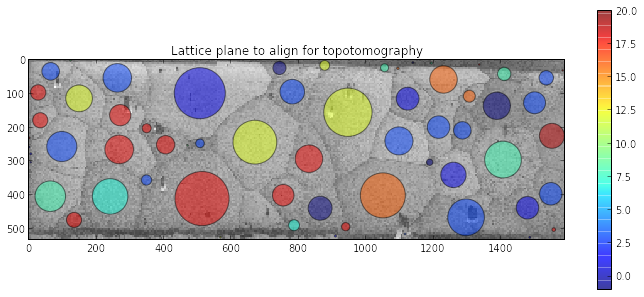

In [53]:
plt.figure(figsize=(12, 5))
plt.imshow(iq.T, origin='upper', interpolation='nearest', cmap=cm.gray,
           extent=(0, scan_step * iq.shape[0], scan_step * iq.shape[1], 0))
plt.scatter(grains[:, 4], grains[:, 5], s=grains[:, 6], c=hkl_to_align, alpha=0.5, vmax=20)
plt.title('Lattice plane to align for topotomography')
plt.colorbar()
plt.axis([0, 1589, 534, 0])